In [19]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt # Core plotting support
from matplotlib import cm

In [20]:
# Upwind Scheme

space_min = -5.0
space_max = 5
spatial_step = 0.01
s_ax = (space_max - space_min) /spatial_step

t_init = 0.0
t_step = 0.1
t_max = 120 #seconds
t_ax = (t_max -t_init) / t_step

spatial_domain = np.arange(space_min, space_max, spatial_step)

rho_init = np.zeros(spatial_domain.shape)

rho_init[spatial_domain <= 0.0] = 160
rho_init[spatial_domain < -0.25] = 80

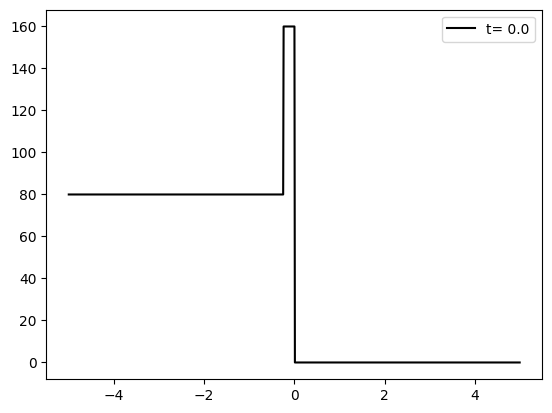

In [21]:
plt.plot(spatial_domain, rho_init, label='t= 0.0', color='black')
plt.legend()
plt.show()

In [22]:
dt = (t_step / 3600) / spatial_step
grid = np.zeros((int(t_ax), int(s_ax)))
grid[0] = rho_init
v_max = 120
rho_max = 160

for j in range(1, int(t_ax)):
  for i in range(0, int(s_ax)-1):
    n = grid[j-1, i+1]
    rho1 = (1.0 - (n/rho_max)) * n
    rho2 = (1.0 - (grid[j-1, i] / rho_max)) * grid[j-1, i]
    rho = grid[j-1, i] - ((dt * v_max)) * (rho1-rho2)
    if rho > rho_max:
      rho = rho_max
    if rho < 0:
      rho = 0
    grid[j,i] =  rho
  grid[j, -1] = grid[j,0]
grid[grid < 0] = 0 


Text(0.5, 0, 'density')

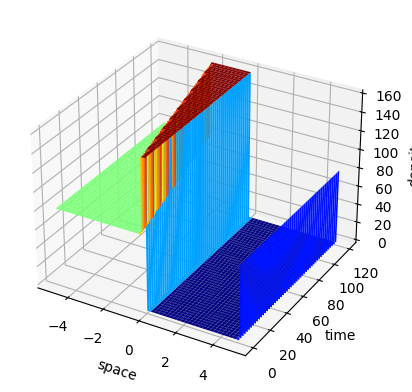

In [23]:
x = np.arange(0.0, 120.0, 0.1)
X, Y = np.meshgrid(spatial_domain, x)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, grid, cmap=cm.jet)
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('density')

In [24]:
# Lax-Friederichs

# Fundamental Diagram
def flow(rho):
  return v_max * rho * (1 - (rho / rho_max))

lf_grid = np.zeros((int(t_ax), int(s_ax)))
lf_grid[0] = rho_init
lf_grid[0,-1] = lf_grid[0,0]

In [25]:
for j in range(1, int(t_ax)):
  for i in range(0, int(s_ax)-1):
    p1 = (lf_grid[j-1, i+1] + lf_grid[j-1,i-1]) / 2
    p2 = (dt) * ((flow(lf_grid[j-1, i+1]) - flow(lf_grid[j-1,i-1])) / 2)
    p = p1 - p2
    if rho > rho_max:
      rho = rho_max
    lf_grid[j,i] = p
  lf_grid[lf_grid < 0] = 0
  lf_grid[j,-1] = lf_grid[j,0]

Text(0.5, 0, 'density')

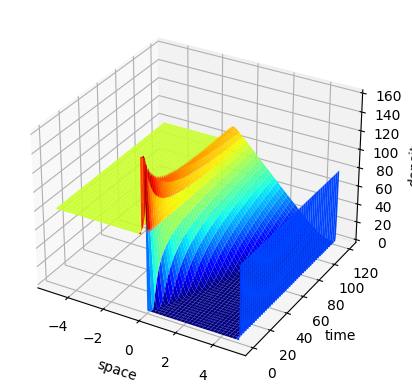

In [26]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,lf_grid, cmap=cm.jet)
ax.set_xlabel('space')
ax.set_ylabel('time')
ax.set_zlabel('density')

In [58]:
# CA

DEF_CMAP = 'binary'

def show_grid(grid, vertical=True, **args):
    if 'cmap' not in args:
        args['cmap'] = DEF_CMAP
    if vertical:
        plt.matshow(grid, **args)
        plt.xlabel('position, $n$')
        plt.ylabel('time, $t$', rotation=0, horizontalalignment='right')
    else:
        plt.matshow(grid, **args)
        plt.ylabel('position, $n$', rotation=0, horizontalalignment='right')
        plt.xlabel('time, $t$')
    clb = plt.colorbar()
    clb.ax.set_title('Car Velocity')
    plt.show()

In [59]:
v_max = 5
num_cells = 300
c_grid = np.empty(num_cells)
c_grid.fill(-1)
time_steps = 100

impulse_start = int(num_cells * (0.5 - 0.025))
impulse_end = int(num_cells * 0.5)

c_grid[0: impulse_start: 2] = 0
c_grid[impulse_start:impulse_end] = 0

def max_available_v(grid, index):
  dist = 0
  for car in range(index + 1, index + v_max):
    if grid[car % len(grid)] != -1:
      return dist
    dist += 1
  return v_max

def update_v(grid, index):
  v = grid[index]
  v = v_max if v + 1 > v_max else v + 1
  max_next_v = max_available_v(grid, index)
  v = max_next_v if v > max_next_v else v
  return v


def update_world(grid):
  new_grid = np.empty(len(grid))
  new_grid.fill(-1)
  for i in range(len(grid)):
    if grid[i] != -1:
      new_velocity = update_v(grid, i)
      new_grid[(i + int(new_velocity)) % len(grid)] = int(new_velocity)
  return new_grid


G = np.ndarray((1, len(c_grid)))
G[0] = c_grid

# simulation step
for t in range(time_steps):
  c_grid = update_world(c_grid)
  G = np.vstack((G, c_grid))



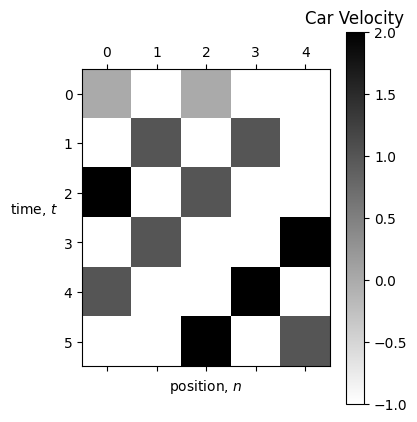

In [60]:
small_grid = np.empty(5)
small_grid.fill(-1)
small_grid[0] = 0
small_grid[2] = 0

X = np.ndarray((1, len(small_grid)))
X[0] = small_grid
for t in range(5):
  small_grid = update_world(small_grid)
  X = np.vstack((X, small_grid))

show_grid(X)

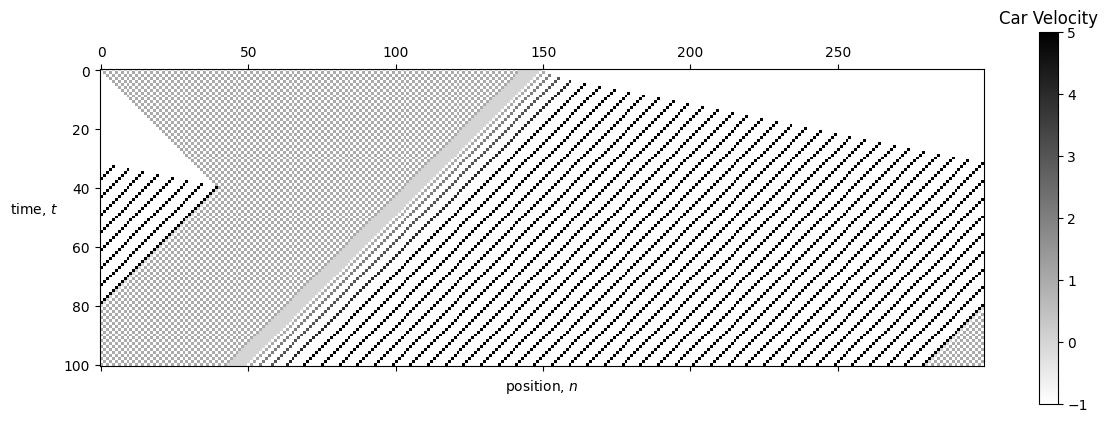

In [61]:
show_grid(G)

In [62]:
# Stochastic Extension

v_max = 5
num_cells = 300
time_steps = 100
dally_factor = 0.05

# initalize car grid
car_grid = np.empty(num_cells)
car_grid.fill(-1)

# calculate distance between subsequent cars
def distance(grid, index):
  dist = 0
  for car_index in range(index + 1, index + v_max):
    if grid[(car_index) % len(grid)] != -1:
      return dist
    dist += 1
  
  return v_max

# update velocity formula
def update_velocity(grid, index):
  v = grid[index]
  v = v_max if v + 1 > v_max else v + 1
  d = distance(grid, index)
  v = d if v > d else v
  v = np.max(v-1, 0) if np.random.rand(1) < dally_factor else v
  return v

# update grid
def update_grid(grid):
  new_grid = np.empty(num_cells)
  new_grid.fill(-1)
  for i in range(len(grid)):
    if grid[i] != -1:
      new_velocity = update_velocity(grid, i)
      new_grid[(i + int(new_velocity)) % len(grid)] = int(new_velocity)

  return new_grid

In [63]:
# initial condition setup
# curr_grid = np.random.randint(-1, 1, (num_cells))
curr_grid = np.empty(num_cells)
curr_grid.fill(-1)

impulse_start = int(num_cells * (0.5 - 0.025))
impulse_end = int(num_cells * 0.5)

curr_grid[0: impulse_start: 2] = 0
curr_grid[impulse_start:impulse_end] = 0

G = np.ndarray((1, num_cells))
G[0] = curr_grid

# simulation step
for t in range(time_steps - 1):
  curr_grid = update_grid(curr_grid)
  G = np.vstack((G, curr_grid))

print(G.shape)

(100, 300)


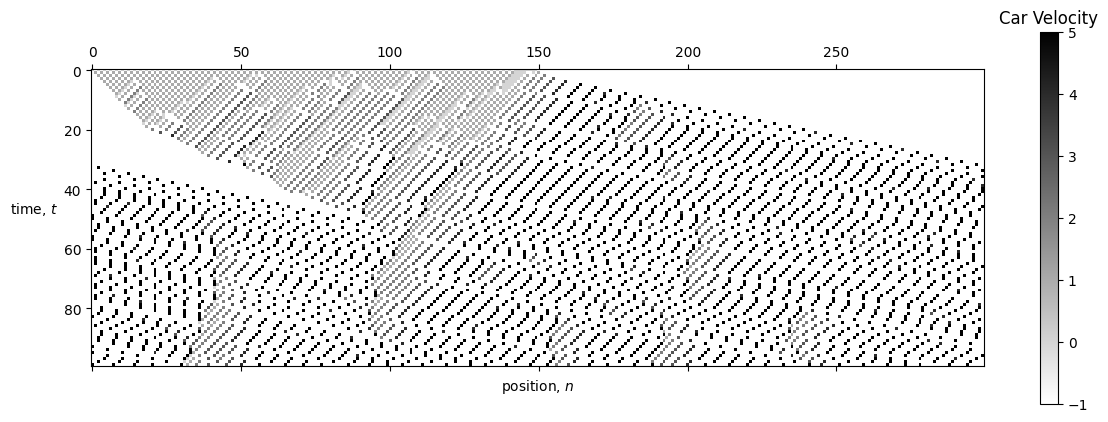

In [64]:
show_grid(G)

(100, 300)


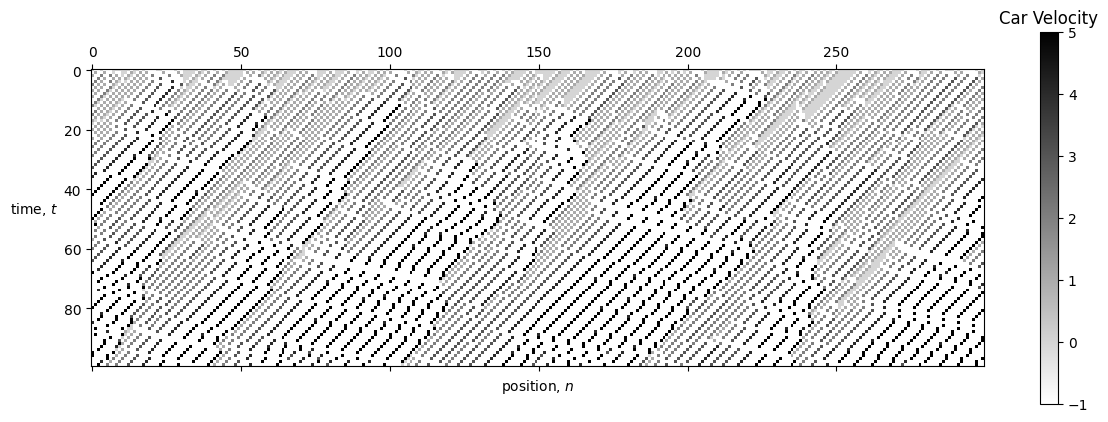

In [65]:
curr_grid = np.random.randint(-1, 1, (num_cells))
G = np.ndarray((1, num_cells))
G[0] = curr_grid

# simulation step
for t in range(time_steps - 1):
  curr_grid = update_grid(curr_grid)
  G = np.vstack((G, curr_grid))

print(G.shape)

show_grid(G)